# Import

In [1]:
import glob, os
from IPython.display import clear_output
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange
import xarray as xr
import dask
import pandas as pd
from IPython import display
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
import inspect
import tensorboard
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
import itertools
import matplotlib.colors as mcolors

In [2]:
import gsw
import xesmf as xe
import xgcm

In [3]:
import logging
logging.getLogger('lightning').setLevel(0)
pl.utilities.distributed.log.setLevel(logging.ERROR)

In [4]:
import platform
print(platform.platform())

Linux-5.4.144+-x86_64-with-glibc2.31


In [5]:
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39885")

# Useful functions

A function that allows to read the logs in tensorboars format and returns them as a python dictionary:

In [7]:
def get_logs_from_tb(exp_name, version_name, directory='logs/') :
    dictionary = dict()
    # for var in list_of_vars :
    #     dictionary[var] = list()
    for event in EventFileLoader(glob.glob(directory + '/' + exp_name + '/' + version_name + '/events.out.*')[0]).Load() :
        if (len(event.summary.value) > 0) :
            if (event.summary.value[0].tag not in dictionary) :
                dictionary[event.summary.value[0].tag] = []
            (dictionary[event.summary.value[0].tag]).append(event.summary.value[0].tensor.float_val)
    return dictionary

## Coarse-graining

In [8]:
metrics = {
    ('X',): ['e1t'], # X distances
    ('Y',): ['e2t'], # Y distances
    ('X', 'Y',): ['area_t'] # Areas 
}

In [9]:
eORCA025_global_mesh = xr.open_dataset('../global_eORCA025_mesh.nc').load()

In [10]:
def coarsen(XdataSet) :
    # prepare input dataset for coarseinig
    input_ds = XdataSet
    # generate corner lat lon
    input_ds = xgcm.autogenerate.generate_grid_ds(input_ds, axes_dims_dict={'X' : 'x', 'Y' : 'y'}, position=('center', 'right'))
    input_ds = xgcm.autogenerate.generate_grid_ds(input_ds, axes_dims_dict={'X' : 'x', 'Y' : 'y'}, axes_coords_dict={'X' : 'lon', 'Y' : 'lat'}, position=('center', 'outer'))
    # adjust names of coords for regridder
    input_ds = input_ds.rename({'x_outer': 'x_b','y_outer': 'y_b', 'x_right' : 'x_r', 'y_right' : 'y_r'})
    input_ds.coords['mask'] = input_ds['tmask']
    input_ds.coords['area_t'] = input_ds['e1t']*input_ds['e2t']
    input_ds.coords['area_u'] = input_ds['e1u']*input_ds['e2u']
    input_ds.coords['area_v'] = input_ds['e1v']*input_ds['e2v']
    input_ds.coords['area_f'] = input_ds['e1f']*input_ds['e2f']
    xgcm_grid_HR = xgcm.Grid(input_ds, metrics=metrics, periodic=False, coords={'X' : {'center' : 'x', 'outer' : 'x_b', 'right' : 'x_r'}, \
                                           'Y' : {'center' : 'y', 'outer' : 'y_b', 'right' : 'y_r'}})
    input_ds.coords['lon_b'] = xgcm_grid_HR.interp(da=input_ds['lon_outer'], axis='Y', to='outer',boundary='extend')
    input_ds.coords['lat_b'] = xgcm_grid_HR.interp(da=input_ds['lat_outer'], axis='X', to='outer',boundary='extend')
    
    # prepare output grid
    grid_LR = eORCA025_global_mesh # - quarter degree global grid
    # to take a part of the global grid corresponding to the data cut
    selection = grid_LR.lon.where((grid_LR.lon>=input_ds.lon.min().values) & (grid_LR.lon<=input_ds.lon.max().values) &\
                                  (grid_LR.lat>=input_ds.lat.min().values) & (grid_LR.lat<=input_ds.lat.max().values), drop=True)
    selected_x = list(selection.x.values)
    selected_y = list(selection.y.values)
    #selected_x_b = [ (element - 0.5) for element in range(selected_x[0], selected_x[-1]+2)]
    #selected_y_b = [ (element - 0.5) for element in range(selected_y[0], selected_y[-1]+2)]
    grid_LR = grid_LR.isel(x=selected_x[0:-1], x_b=selected_x, y=selected_y[0:-1], y_b=selected_y)
    # reinit x and y arrays
    grid_LR.coords['x'] = np.arange(1,len(selected_x))
    grid_LR.coords['y'] = np.arange(1,len(selected_y))
    grid_LR.coords['x_b'] = np.arange(1,len(selected_x)+1)-0.5
    grid_LR.coords['y_b'] = np.arange(1,len(selected_y)+1)-0.5
    # create regridder, i.e. compute weights
    # TODO : save weights and reuse them (can accelerate pre-treatment)
    regridder_with_mask = xe.Regridder(input_ds, grid_LR, method="conservative_normed")
    # perform regridding
    coarsened_ds = regridder_with_mask(input_ds).drop(['x_b', 'y_b', 'x_r', 'y_r', 'lon_b', 'lat_b', 'tmask'])
    coarsened_ds.coords['mask'] = grid_LR['mask']
    coarsened_ds.coords['e1t'] = grid_LR['e1t']
    coarsened_ds.coords['e2t'] = grid_LR['e2t']
    coarsened_ds.coords['area_t'] = coarsened_ds.coords['e1t']*coarsened_ds.coords['e2t']
    coarsened_ds = xgcm.autogenerate.generate_grid_ds(coarsened_ds, axes_dims_dict={'X' : 'x', 'Y' : 'y'}, position=('center', 'right'))
    return coarsened_ds

# Data properties

In [11]:
h = 20 # height of images
w = 20 # width of images

In [12]:
batch_size = 4

In [13]:
import sys
sys.path.insert(1, '..')

In [14]:
import s3fs
from validate_catalog import all_params
params_dict, cat = all_params()

In [15]:
data_dict=[dict() for i in range(6)]
data_dict[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA', 'xy_slice' : dict(x=slice(-380,-10),y=slice(-385,-15))})
data_dict[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO', 'xy_slice' : dict(x=slice(-380,-10),y=slice(-385,-15))})
data_dict[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES FMA', 'xy_slice' : dict(x=slice(-565,-195),y=slice(-385,-15))})
data_dict[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES ASO', 'xy_slice' : dict(x=slice(-565,-195),y=slice(-385,-15))})
data_dict[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA', 'xy_slice' : dict(x=slice(-370,None),y=slice(120,490))})
data_dict[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO', 'xy_slice' : dict(x=slice(-370,None),y=slice(120,490))})

In [16]:
time_slice = dict(time_counter=slice(0,-1,1))

In [17]:
features_to_add_to_sample = ['sigma0_model', 'sosstsst', 'sosaline', 'diff_sosaline_sqr', 'rho_sa_sa', 'rho_sa_ct', 'diff_sosstsst_sqr', 'rho_ct_ct',\
                             'predictor_T', 'predictor_S', 'predictor_TS',\
                             'sigma0_delta']

Evaluation loss function:

In [18]:
eval_loss = torch.nn.MSELoss(reduction='none') 

# Data classes

The proposed implementation of the ``pytorch Dataset`` class reads netcdf files with data and can transform it for pytorch tensors. It allows to choose any number of netcdf files that will form the dataset and adjust the quantity of time snapshots taken from files. It also can perform normalization by mean and std of a variable in the file (so that the average is performed individually for each region and season). It is possible to create a dataset from 1 region and season, or to combine few one them (by combining files) and shuffle the snapshots in the training dataset.

In [19]:
# coefficient c in the deterministic parametrization (the one that needs calibrated)
coef_determ_param = 0.27354727590256256

## Pytorch dataset

In [20]:
class SalinityTemperatureDensityDataset(torch.utils.data.Dataset):
    """Dataset of 2D maps of surface temperature, salinity"""

    def __init__(self, xarray_dataset, select='All', portion_of_time_series=0.5, transform=None):
        self.transform = transform
        full_data_file_len = len(xarray_dataset['time_counter'])
        if (select == 'All') :
            time_index_range = np.arange(0, data_file_len)
        elif (select == 'First') :
            time_index_range = np.arange(0, int(portion_of_time_series*full_data_file_len)+1)
        elif (select == 'Last') :
            time_index_range = np.arange(int((1-portion_of_time_series)*full_data_file_len), full_data_file_len)
        self.data = xarray_dataset.isel(time_counter=time_index_range)
        self.data_file_len = len(self.data['time_counter'])
        
    def __len__(self):
        return self.data_file_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            list_idx = idx.tolist()
        else :
            list_idx = idx
        selected_time_frames = self.data.isel(time_counter=list_idx)
        
        # create dictionary of a sample (a batch) containig different features. 
        # This dictionary is sort of an intermediate step, preparing xArray data for trasform into pytorch tensors
        sample = dict()
        for feature in features_to_add_to_sample :
            sample[feature] = selected_time_frames[feature].values  # transform to a numpy array
            # mean and std of the FILE dataset (to avoid batch avg) for possible normalization
            sample['mean_'+feature] = selected_time_frames.attrs['mean_'+feature].values
            sample['std_'+feature] = selected_time_frames.attrs['std_'+feature].values
            sample['median_'+feature] = selected_time_frames.attrs['median_'+feature].values
            sample['normalized_'+feature] = ((selected_time_frames[feature]-sample['mean_'+feature])/sample['std_'+feature]).values
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def restore_units(tensor, sample, reference_feature) :
        return tensor*(sample['std_'+reference_feature].view(-1,1,1))+sample['mean_'+reference_feature].view(-1,1,1)
                
    def normalize(tensor, sample, reference_feature) :
        return (tensor-sample['mean_'+reference_feature].view(-1,1,1))/(sample['std_'+reference_feature].view(-1,1,1))

In [21]:
class ToTensor(object):
    """Convert each numpy array in sample to Tensors."""

    def __call__(self, sample):
        transformed_sample=sample.copy()
        for feature in features_to_add_to_sample :
            transformed_sample[feature] = torch.tensor(sample[feature])
        return transformed_sample

## PyLi data module

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is consistent data splits, data preparation and transforms across models.

In [22]:
# only xarray data pretreatment here: slicing, filtering, computation of some variables
def xr_data_prep_pipeline(in_xr_dataset, data_dict_entity) :
    # drop not used variables
    HR_data = in_xr_dataset.drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    # time and space slicing
    data_slice = dict(time_slice | data_dict_entity['xy_slice'])
    HR_data=HR_data.isel(data_slice)
    
    # compute "true" density (before filtering
    # density anomaly (sigma0). denoted as 'true' since is computed on the basis of original (non-filtered) HR data
    HR_data['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, HR_data['sosaline'], HR_data['sosstsst'], dask='parallelized')
    # sqr of conservative temperature (to compute the subgrid variance further)
    HR_data['sst_sqr'] = HR_data['sosstsst']**2
    HR_data['sal_sqr'] = HR_data['sosaline']**2
    
    # apply filtering/coarsening
    LR_data = coarsen(HR_data)
    
    # variables to compute after filtering:
    LR_data = LR_data.assign(var_T = LR_data['sst_sqr'] - LR_data['sosstsst']**2)
    LR_data = LR_data.assign(var_S = LR_data['sal_sqr'] - LR_data['sosaline']**2)
    LR_data = LR_data.assign(sigma0_model = xr.apply_ufunc(gsw.density.sigma0, LR_data['sosaline'], LR_data['sosstsst'], dask='parallelized'))
    LR_data = LR_data.assign(sigma0_delta = LR_data['sigma0_true'] - LR_data['sigma0_model'])
    
    # density derivative (EOS)
    # a weird round-about because of issues in implementation of gsw python (does not support dask, needs numpy input/output)
    LR_data = LR_data.assign(pressure = xr.zeros_like(LR_data.sosstsst))
    temp_array = xr.apply_ufunc(gsw.rho_second_derivatives, LR_data.sosaline, LR_data.sosstsst, LR_data.pressure, \
                            input_core_dims = [('time_counter', 'y', 'x') for i in range(3)],\
                           output_core_dims = [('time_counter', 'y', 'x') for i in range(5)],\
                           dask='parallelized', dask_gufunc_kwargs=dict({'allow_rechunk' : True})) 
    LR_data = LR_data.assign(rho_sa_sa = xr.DataArray(temp_array[0], dims=['time_counter', 'y', 'x']))
    LR_data = LR_data.assign(rho_sa_ct = xr.DataArray(temp_array[1], dims=['time_counter', 'y', 'x']))
    LR_data = LR_data.assign(rho_ct_ct = xr.DataArray(temp_array[2], dims=['time_counter', 'y', 'x']))
    LR_data = LR_data.assign(rho_sa_p = xr.DataArray(temp_array[3], dims=['time_counter', 'y', 'x']))
    LR_data = LR_data.assign(rho_ct_p = xr.DataArray(temp_array[4], dims=['time_counter', 'y', 'x']))
    del temp_array
    
    # spatial finite differences
    LR_data = xgcm.autogenerate.generate_grid_ds(LR_data, axes_dims_dict={'X' : 'x', 'Y' : 'y'}, position=('center', 'right'))
    xgcm_grid_LR = xgcm.Grid(LR_data, metrics=metrics, periodic=False, coords={'X' : {'center' : 'x', 'right' : 'x_right'}, \
                                                                                  'Y' : {'center' : 'y', 'right' : 'y_right'}})
    for var in ['sosstsst', 'sosaline'] :
        LR_data['diff_'+var+'_sqr'] = xgcm_grid_LR.interp(xgcm_grid_LR.diff(LR_data[var], 'X', boundary='extend')**2, 'X') + \
                                   xgcm_grid_LR.interp(xgcm_grid_LR.diff(LR_data[var], 'Y', boundary='extend')**2, 'Y')
    
    # predictors for the parametrization
    LR_data = LR_data.assign(predictor_T = 0.5*LR_data['rho_ct_ct']*LR_data['diff_sosstsst_sqr'])
    LR_data = LR_data.assign(predictor_S = 0.5*LR_data['rho_sa_sa']*LR_data['diff_sosaline_sqr'])
    LR_data = LR_data.assign(predictor_TS = 0.5*LR_data['rho_sa_ct']*np.sqrt(LR_data['diff_sosstsst_sqr']*LR_data['diff_sosaline_sqr']))
        
    # cut a slice in space (to make samples from different datasets of the same size)
    LR_data = LR_data.isel(x=slice(None,w), y=slice(None,h))

    # again drop non-used vars and coords
    LR_data = LR_data.drop(['time_centered', 'tmask', 'nav_lat', 'nav_lon', 'depth', 'e1f', 'e2f', 'e1u', 'e2u', \
                                      'e1v', 'e2v', 'e1t', 'e2t', 'sigma0_true', 'sst_sqr', 'sal_sqr'], errors='ignore')
    return LR_data

In [23]:
from pytorch_lightning.trainer.supporters import CombinedLoader

class PyLiDataModule(pl.LightningDataModule):
    def __init__(self, cloud_data_sets, batch_size):
        super().__init__()
        self.cloud_data_sets = cloud_data_sets
        self.batch_size = batch_size
        self.list_of_xr_datasets = [xr.Dataset() for i in range(len(self.cloud_data_sets))]
        for i, dictionary in enumerate(self.cloud_data_sets) :
            temp_xr_ds = cat.eNATL60(region=dictionary['region'],datatype='surface_hourly', season=dictionary['season']).to_dask()
            temp_xr_ds = xr_data_prep_pipeline(temp_xr_ds, dictionary)
            temp_xr_ds = temp_xr_ds[features_to_add_to_sample].load()
            self.list_of_xr_datasets[i] = temp_xr_ds
    def prepare_data(self):
        for ds in self.list_of_xr_datasets :
            for feature in features_to_add_to_sample :
                ds.attrs['mean_'+feature] = ds.data_vars[feature].mean(skipna=True).compute()
                ds.attrs['std_'+feature] = ds.data_vars[feature].std(skipna=True).compute()  
                ds.attrs['median_'+feature] = ds.data_vars[feature].median(skipna=True).compute()  
                ds[feature] = ds[feature].fillna(ds.attrs['median_'+feature])
                
    def train_dataloader(self):
        # takes first 60% of time snapshots for training
        train_datasets = torch.utils.data.ConcatDataset([SalinityTemperatureDensityDataset(xr_dataset, select='First', portion_of_time_series=0.6, transform=ToTensor()) \
                           for xr_dataset in self.list_of_xr_datasets])
        return torch.utils.data.DataLoader(train_datasets, batch_size=self.batch_size, shuffle=True, drop_last=True)
    def val_dataloader(self):
        # takes last 20% of time snapshots for validation
        val_datasets = torch.utils.data.ConcatDataset([SalinityTemperatureDensityDataset(xr_dataset, select='Last', portion_of_time_series=0.2, transform=ToTensor()) \
                          for xr_dataset in self.list_of_xr_datasets])
        return torch.utils.data.DataLoader(val_datasets, batch_size=self.batch_size, drop_last=True) 
    def test_dataloader(self):
        test_datasets = [SalinityTemperatureDensityDataset(xr_dataset, select='Last', portion_of_time_series=0.2, transform=ToTensor()) \
                          for xr_dataset in self.list_of_xr_datasets]
        return [torch.utils.data.DataLoader(dataset, batch_size=1, drop_last=True) for dataset in test_datasets]
    
    # def setup(self, stage):
    #     make assignments here (val/train/test split)
    #     called on every process in DDP
    #def teardown(self):
        # clean up after fit or test
        # called on every process in DDP

## Initialize data module

In [24]:
%%time
common_datamodule = PyLiDataModule(data_dict, batch_size=batch_size)
#common_datamodule.prepare_data()

CPU times: user 30.3 s, sys: 987 ms, total: 31.3 s
Wall time: 1min 51s


# Experiment class

This class collects all information needed for an experiment:

In [40]:
class Experiment :
    log_directory='logs/'
    
    def __init__(self, pl_class, model, label, version_name, datamodule, input_features, target_features, max_epochs=None, limit_train_batches=1.0) :
        super().__init__()
        self.pl_class = pl_class  # pytorch lightning module class
        self.model = model
        self.label = label
        self.version_name = version_name
        self.datamodule = datamodule
        self.input_features = input_features
        self.target_features = target_features
        self.max_epochs = max_epochs
        self.limit_train_batches = limit_train_batches
        
    def run(self) :
        self.NN = self.pl_class(self.model, self.input_features, self.target_features)
        self.logger = pl_loggers.TensorBoardLogger(save_dir=self.log_directory, name=self.label, version=self.version_name)
        self.checkpoint_callback = ModelCheckpoint(dirpath=self.log_directory + self.label + "/" + self.version_name, \
                                              save_top_k=2, monitor="loss_val")
    
        self.trainer = pl.Trainer(max_epochs=self.max_epochs, logger=self.logger, limit_train_batches=self.limit_train_batches, \
                                  callbacks=[EarlyStopping(monitor="loss_val", mode="min"), self.checkpoint_callback],\
                                  accelerator='gpu', devices=(1 if torch.cuda.is_available() else None))  
        self.trainer.fit(model = self.NN, datamodule=self.datamodule)
        self.logs = get_logs_from_tb(exp_name=self.label, version_name=self.version_name, directory=self.log_directory)
        
    def test(self) :
        return self.trainer.test(self.NN, datamodule=self.datamodule)

# Linear regression (deterministic parametrization)

In [41]:
class LitLinRegression(pl.LightningModule):
    def __init__(self, nnModel, inputs, outputs):
        super().__init__()
        self.nnModel = nnModel
        self.inputs = inputs
        self.outputs = outputs
        nnModel.weight.data = torch.Tensor([1.0])
        self.loss = torch.nn.HuberLoss(reduction='mean', delta=0.9)
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = self.loss(y_model, y_true)  
        self.log_dict({'loss_train' : loss, 'coef_train' : self.nnModel.weight.data}, on_step=False, on_epoch=True)
        return loss

    # validation logics (is evaluated during the training, but the data is not used to the optimization loop)
    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = self.loss(y_model, y_true)  
        self.log('loss_val', loss, on_step=False, on_epoch=True) 
    
    # gives model output in a form of a dictionary of 2d variables
    def predict_step(self, batch, batch_idx, dataloader_idx) :
        x = self.transform_input(batch)
        tensor_model_output = self.nnModel(x)
        pred = dict()
        pred['sigma0_delta'] = tensor_model_output.view(-1,h,w)
        return pred
        
    # testing logic - to evaluate the model after training
    def test_step(self, batch, batch_idx, dataloader_idx) :
        model_output = self.predict_step(batch, batch_idx, dataloader_idx)
        loss = dict()
        for i, feature in enumerate(self.outputs) : 
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                loss[not_normalized_feature] = eval_loss(model_output[not_normalized_feature], batch[not_normalized_feature])
                self.log('loss_test_'+not_normalized_feature, loss[not_normalized_feature].mean())
            loss[feature] = eval_loss(model_output[feature], batch[feature])
            self.log('loss_test_'+feature, loss[feature].mean())

    def configure_optimizers(self) :
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        #optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer
    
    def transform_input(self, batch) :
        # since the data is treated pixel-by-pixel, the actual batch for training will actually consist of all points of all batches. 
        # this part flattens the 2d maps of different variables 
        transform = torch.hstack([batch[key].view(-1,1) for key in self.inputs]).to(torch.float32)
        return transform
    
    def transform_target(self, batch) : 
        if (len(self.outputs) > 1) :
            target_transformed = torch.hstack([batch[key].view(-1,1) for key in self.outputs]).to(torch.float32)
        else :
            target_transformed = batch[self.outputs[0]].view(-1).to(torch.float32)
        return target_transformed

In [42]:
lin_model = torch.nn.Linear(1, 1, bias=False)

In [43]:
exp_lin = Experiment(pl_class=LitLinRegression, \
                      model=lin_model, \
                      label='linear_reg', \
                      version_name='version_0_batch4', \
                      input_features=['predictor_T'], \
                      target_features=['sigma0_delta'], 
                      datamodule=common_datamodule,\
                      max_epochs=70, \
                      limit_train_batches=1.0) 

In [44]:
exp_lin.run()
clear_output(wait=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'nnModel' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnModel'])`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | nnModel | Linear    | 1     
1 | loss    | HuberLoss | 0     
--------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [45]:
best_lin_regr_model = LitLinRegression.load_from_checkpoint(exp_lin.checkpoint_callback.best_model_path)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'nnModel' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnModel'])`.
  rank_zero_warn(


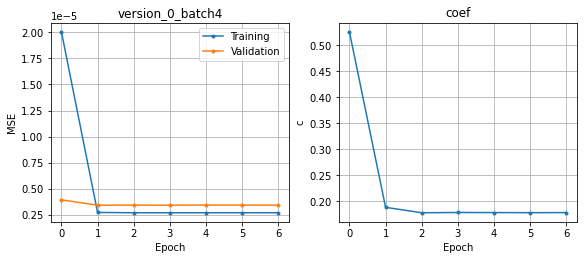

In [46]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 3.5))
ax[0].plot(exp_lin.logs['loss_train'], '.-', label='Training')
ax[0].plot(exp_lin.logs['loss_val'], '.-', label='Validation')
ax[0].set(title=exp_lin.version_name, xlabel='Epoch', ylabel='MSE'); ax[0].grid(True)
ax[0].set(ylabel='MSE')
ax[0].legend()

ax[1].plot(exp_lin.logs['coef_train'], '.-')
ax[1].set(title='coef', ylabel='c', xlabel='Epoch', yscale='linear');ax[1].grid()
plt.show()

Found calibration coefficient:

In [47]:
best_lin_regr_model.nnModel.weight.data

tensor([0.1734])

# Fully-connected NN

The pytorch lightning class describing a model that treats the inputs/outputs pixel by pixel. 

In [48]:
class LitPixelModel(pl.LightningModule):
    def __init__(self, nnModel, inputs, outputs):
        super().__init__()
        self.nnModel = nnModel
        # initialization of model parameters with random numbers 
        # for name, param in nnModel.named_parameters():
        #     param.data.normal_(mean=0.0, std=1.0)
        self.inputs = inputs
        self.outputs = outputs
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_train', loss, on_step=False, on_epoch=True)
        return loss

    # validation logics (is evaluated during the training, but the data is not used to the optimization loop)
    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_val', loss, on_step=False, on_epoch=True) 
    
    # gives model output in a form of a dictionary of 2d variables
    def predict_step(self, batch, batch_idx, dataloader_idx) :
        x = self.transform_input(batch)
        tensor_model_output = self.nnModel(x)
        pred = dict()
        for i, feature in enumerate(self.outputs) :
            pred[feature] = tensor_model_output[:,i].view(-1,h,w)
            # if outputs are normalized then compute also result in the restored units (not normalized)
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                pred[not_normalized_feature] = SalinityTemperatureDensityDataset.restore_units(pred[feature], batch, not_normalized_feature)
        return pred
        
    # testing logic - to evaluate the model after training
    def test_step(self, batch, batch_idx, dataloader_idx) :
        model_output = self.predict_step(batch, batch_idx, dataloader_idx)
        loss = dict()
        for i, feature in enumerate(self.outputs) : 
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                loss[not_normalized_feature] = eval_loss(model_output[not_normalized_feature], batch[not_normalized_feature])
                self.log('loss_test_'+not_normalized_feature, loss[not_normalized_feature].mean())
            loss[feature] = eval_loss(model_output[feature], batch[feature])
            self.log('loss_test_'+feature, loss[feature].mean())

    def configure_optimizers(self) :
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        #optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer
    
    def transform_input(self, batch) :
        # since the data is treated pixel-by-pixel, the actual batch for training will actually consist of all points of all batches. 
        # this part flattens the 2d maps of different variables 
        transform = torch.hstack([batch[key].view(-1,1) for key in self.inputs]).to(torch.float32)
        return transform
    
    def transform_target(self, batch) : 
        target_transformed = torch.hstack([batch[key].view(-1,1) for key in self.outputs]).to(torch.float32)
        return target_transformed

## Experiment 0 (FCNN on predictors)

In [88]:
class FCNN(torch.nn.Module):
    def __init__(self, nb_input_features_FCNN, nb_target_features_FCNN):
        super().__init__()
        self.lin1 = torch.nn.Linear(nb_input_features_FCNN, 8)
        self.lin2 = torch.nn.Linear(8, 16)
        self.lin3 = torch.nn.Linear(16, 8)
        self.lin4 = torch.nn.Linear(8, nb_target_features_FCNN)

    def forward(self, x):
        #flatten_input = nn.Flatten(x)
        res = self.lin1(x)
        res = torch.nn.functional.relu(res)
        res = self.lin2(res)
        res = torch.nn.functional.relu(res)
        res = self.lin3(res)
        res = torch.nn.functional.relu(res)
        res = self.lin4(res)
        return res

In [89]:
exp0 = Experiment(pl_class=LitPixelModel, \
                      model=FCNN(3,1), \
                      label='FCNN', \
                      version_name='version_0_batch4', \
                      input_features=['normalized_predictor_T', 'normalized_predictor_S', 'normalized_predictor_TS'], \
                      target_features=['normalized_sigma0_delta'], 
                      datamodule=common_datamodule,\
                      max_epochs=50, \
                      limit_train_batches=1.0) 

In [90]:
exp0.run()
clear_output(wait=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'nnModel' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnModel'])`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | nnModel | FCNN | 321   
---------------------------------
321       Trainable params
0         Non-trainable params
321       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

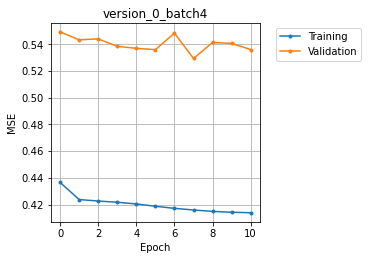

In [91]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3.5), sharey=True)
ax.plot(exp0.logs['loss_train'], '.-', label='Training')
ax.plot(exp0.logs['loss_val'], '.-', label='Validation')
ax.set(title=exp0.version_name, xlabel='Epoch', ylabel='MSE'); ax.grid(True)
ax.set(ylabel='MSE')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Experiment on predictors non-normalized

In [93]:
exp_NonNorm = Experiment(pl_class=LitPixelModel, \
                      model=layer4_FCNN_model, \
                      label='FCNN', \
                      version_name='nonnorm_batch4', \
                      input_features=['predictor_T', 'predictor_S', 'predictor_TS'], \
                      target_features=['sigma0_delta'], 
                      datamodule=common_datamodule,\
                      max_epochs=50, \
                      limit_train_batches=1.0) 

In [94]:
exp_NonNorm.run()
clear_output(wait=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'nnModel' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnModel'])`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:107: UserWarning: attribute 'nnModel' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | nnModel | FCNN | 321   
---------------------------------
321       Trai

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

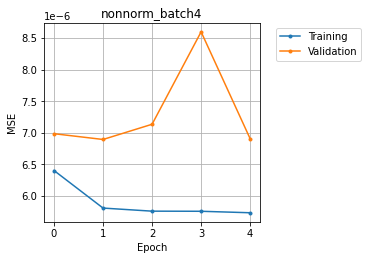

In [95]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3.5), sharey=True)
exp = exp_NonNorm 
ax.plot(exp.logs['loss_train'], '.-', label='Training')
ax.plot(exp.logs['loss_val'], '.-', label='Validation')
ax.set(title=exp.version_name, xlabel='Epoch', ylabel='MSE'); ax.grid(True)
ax.set(ylabel='MSE')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Experiment FCNN on diffs and derivs

In [74]:
exp_5inputs = Experiment(pl_class=LitPixelModel, \
                      model=FCNN(5,1), \
                      label='FCNN', \
                      version_name='diffs_and_deriv_batch4', \
                      input_features=['normalized_diff_sosstsst_sqr', 'normalized_diff_sosaline_sqr', 'normalized_rho_sa_sa', 'normalized_rho_sa_ct', 'normalized_rho_ct_ct'], \
                      target_features=['normalized_sigma0_delta'], 
                      datamodule=common_datamodule,\
                      max_epochs=50, \
                      limit_train_batches=1.0) 

In [75]:
exp_5inputs.run()
clear_output(wait=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'nnModel' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnModel'])`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | nnModel | FCNN | 337   
---------------------------------
337       Trainable params
0         Non-trainable params
337       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

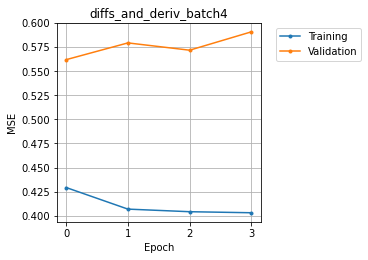

In [78]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3.5), sharey=True)
exp = exp_5inputs 
ax.plot(exp.logs['loss_train'], '.-', label='Training')
ax.plot(exp.logs['loss_val'], '.-', label='Validation')
ax.set(title=exp.version_name, xlabel='Epoch', ylabel='MSE'); ax.grid(True)
ax.set(ylabel='MSE')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Compare

In [96]:
list_of_experiments = [exp_lin, exp0, exp_NonNorm, exp_5inputs]

In [97]:
loss_vs_dataset = [dict() for i in range(len(list_of_experiments))]

for i, exp in enumerate(list_of_experiments) :
    test_dict = exp.test();
    for feature in ['sigma0_delta', 'normalized_sigma0_delta'] :
        if 'loss_test_'+feature+'/dataloader_idx_0' in test_dict[0] :
            loss_vs_dataset[i][feature] = [test_dict[ds]['loss_test_'+feature+'/dataloader_idx_'+str(ds)] for ds in range(len(data_dict))]
clear_output(wait=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1             DataLoader 2
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 loss_test_sigma0_delta   2.9807622923288043e-05    5.105772301198276e-06    5.737553304125882e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 3             DataLoader 4             DataLoader 5
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 loss_test_sigma0_delta    8.23433098531313e-07     2.760547070931031e-09   1.1844990577516584e-08
─────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0                     DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loss_test_normalized_sigma0_delta       0.49719464241355577               0.765852140645857
     loss_test_sigma0_delta           2.9188903647556786e-05            5.395201203682459e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 2                     DataLoader 3
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loss_test_normalized_sigma0_del

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1             DataLoader 2
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 loss_test_sigma0_delta   2.9758629394331824e-05    5.117980826040378e-06   5.8727750980849735e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 3             DataLoader 4             DataLoader 5
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 loss_test_sigma0_delta   1.1280296847286134e-06   5.0543035099967756e-09   1.2766480968784152e-08
─────────

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:107: UserWarning: attribute 'nnModel' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0                     DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loss_test_normalized_sigma0_delta       0.4305388465028228               0.5948005190098868
     loss_test_sigma0_delta            2.527572872888728e-05            4.190193257678732e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 2                     DataLoader 3
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loss_test_normalized_sigma0_del

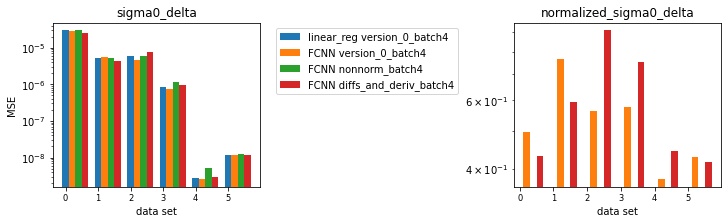

In [100]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
#fig.suptitle(r'Spatial correlation coefficient averaged in time: $R(\rho_c, parametrization)$')
x = np.arange(len(data_dict))
bar_width = 0.2

for col, feature in enumerate(['sigma0_delta', 'normalized_sigma0_delta']) :
    for ib, exp in enumerate(list_of_experiments) :
        if (feature in loss_vs_dataset[ib].keys()) :
            ax[col].bar(x+ib*bar_width, loss_vs_dataset[ib][feature], width=bar_width, label=exp.label+' '+exp.version_name, \
                        color=list(mcolors.TABLEAU_COLORS.values())[ib])
    ax[col].set(title=feature)
for axis in ax :
    axis.set_xlabel('data set')
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='log')
ax[0].set(ylabel='MSE')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Convolutional NN model

In [54]:
class first_CNN(torch.nn.Module):
    def __init__(self, len_keys_input_CNN, len_keys_targets_CNN):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(len_keys_input_CNN, 32, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv4 = torch.nn.Conv2d(128, 64, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv5 = torch.nn.Conv2d(64, len_keys_targets_CNN, kernel_size=3, padding='same', padding_mode='replicate')

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        
        # conv layer 2
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)

        # conv layer 2
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
    
        # conv layer 2
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        
        # conv layer 5 
        x = self.conv5(x)
        
        return x        

In [55]:
modelCNN = (first_CNN(2,1).double())

In [56]:
class CNN_Model_Class(pl.LightningModule):
    def __init__(self, nnModel, inputs, outputs):
        super().__init__()
        self.nnModel = nnModel
        # for name, param in nnModel.named_parameters():
        #     param.data.normal_(mean=0.0, std=0.1)
        self.inputs = inputs
        self.outputs = outputs
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_train', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_val', loss, on_step=False, on_epoch=True) 
    
    def predict_step(self, batch, batch_idx, dataloader_idx) :        
        x = self.transform_input(batch)
        tensor_model_output = self.nnModel(x)
        pred = dict()
        for i, feature in enumerate(self.outputs) :
            pred[feature] = tensor_model_output[:,i,:,:]
            # if outputs are normalized then compute also result in the restored units (not normalized)
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                pred[not_normalized_feature] = SalinityTemperatureDensityDataset.restore_units(pred[feature], batch, not_normalized_feature)
        return pred
        
    def test_step(self, batch, batch_idx, dataloader_idx) :
        model_output = self.predict_step(batch, batch_idx, dataloader_idx)
        loss = dict()        
        for i, feature in enumerate(self.outputs) : 
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                loss[not_normalized_feature] = eval_loss(model_output[not_normalized_feature], batch[not_normalized_feature])
                self.log('loss_test_'+not_normalized_feature, loss[not_normalized_feature].mean())
            loss[feature] = eval_loss(model_output[feature], batch[feature])
            self.log('loss_test_'+feature, loss[feature].mean())

    def configure_optimizers(self) :
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        #optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer

    def transform_input(self, batch) :
        return torch.transpose(torch.stack([batch[key] for key in self.inputs]), 0, 1)

    def transform_target(self, batch) : 
        return torch.transpose(torch.stack([batch[key] for key in self.outputs]), 0, 1)

In [57]:
# print('Input data for training contains ' + str(len(train_data_loader)) + ' batches, each batch contains ' + str(batch_size) + \
#       ' instanteneous 2D maps of ' +str(len(keys_input_CNN)) + ' channels: ' + str(keys_input_CNN) + ' of size ' + str(h)+'x'+str(w) + ' pixels.')

## Experiment 1 (normalized)

In [58]:
exp1 = Experiment(pl_class=CNN_Model_Class, \
                      model=modelCNN, \
                      label='CNN', \
                      version_name='version_0_batch4', \
                      input_features={'normalized_sosstsst', 'normalized_rho_ct_ct'}, \
                      target_features={'normalized_sigma0_delta'}, 
                      datamodule=common_datamodule,
                      max_epochs=50, \
                      limit_train_batches=1.0) 

In [59]:
exp1.run()
clear_output(wait=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'nnModel' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnModel'])`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | nnModel | first_CNN | 167 K 
--------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.669     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

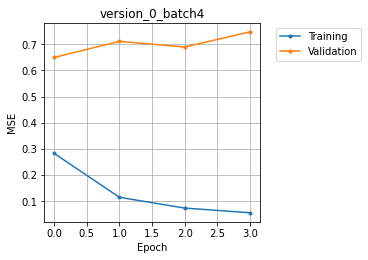

In [60]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3.5), sharey=True)
ax.plot(exp1.logs['loss_train'], '.-', label='Training')
ax.plot(exp1.logs['loss_val'], '.-', label='Validation')
ax.set(title=exp1.version_name, xlabel='Epoch', ylabel='MSE'); ax.grid(True)
ax.set(ylabel='MSE')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Experiment 2 (non-normalized)

In [102]:
exp2 = Experiment(pl_class=CNN_Model_Class, \
                      model=modelCNN, \
                      label='CNN', \
                      version_name='nonnorm_batch4', \
                      input_features={'sosstsst', 'rho_ct_ct'}, \
                      target_features={'sigma0_delta'}, 
                      datamodule=common_datamodule,
                      max_epochs=50, \
                      limit_train_batches=1.0) 

In [103]:
exp2.run()
clear_output(wait=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'nnModel' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnModel'])`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | nnModel | first_CNN | 167 K 
--------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.669     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

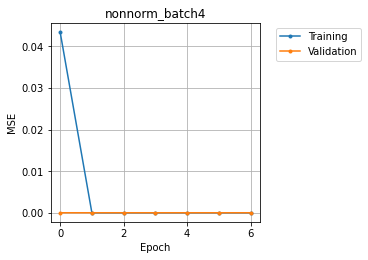

In [104]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3.5), sharey=True)
exp = exp2 
ax.plot(exp.logs['loss_train'], '.-', label='Training')
ax.plot(exp.logs['loss_val'], '.-', label='Validation')
ax.set(title=exp.version_name, xlabel='Epoch', ylabel='MSE'); ax.grid(True)
ax.set(ylabel='MSE')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Experiment 3 (more variables, normalized)

In [119]:
exp3 = Experiment(pl_class=CNN_Model_Class, \
                      model=first_CNN(6,1).double(), \
                      label='CNN', \
                      version_name='more_vars_batch4', \
                      input_features={'normalized_sosstsst', 'normalized_sosaline', 'normalized_sigma0_model', 'normalized_rho_ct_ct', 'normalized_rho_sa_sa', 'normalized_rho_sa_ct'}, \
                      target_features={'normalized_sigma0_delta'}, 
                      datamodule=common_datamodule,
                      max_epochs=50, \
                      limit_train_batches=1.0) 

In [120]:
exp3.run()
clear_output(wait=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'nnModel' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnModel'])`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | nnModel | first_CNN | 168 K 
--------------------------------------
168 K     Trainable params
0         Non-trainable params
168 K     Total params
0.674     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

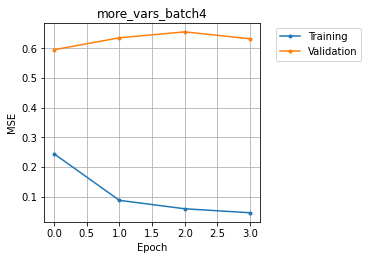

In [122]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3.5), sharey=True)
exp = exp3
ax.plot(exp.logs['loss_train'], '.-', label='Training')
ax.plot(exp.logs['loss_val'], '.-', label='Validation')
ax.set(title=exp.version_name, xlabel='Epoch', ylabel='MSE'); ax.grid(True)
ax.set(ylabel='MSE')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Compare

In [123]:
list_of_experiments = [exp_lin, exp1, exp2, exp3]

In [124]:
loss_vs_dataset = [dict() for i in range(len(list_of_experiments))]

for i, exp in enumerate(list_of_experiments) :
    test_dict = exp.test();
    for feature in ['sigma0_delta', 'normalized_sigma0_delta'] :
        if 'loss_test_'+feature+'/dataloader_idx_0' in test_dict[0] :
            loss_vs_dataset[i][feature] = [test_dict[ds]['loss_test_'+feature+'/dataloader_idx_'+str(ds)] for ds in range(len(data_dict))]
clear_output(wait=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1             DataLoader 2
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 loss_test_sigma0_delta   2.9807622923288026e-05    5.10577230119828e-06    5.7375533041258834e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 3             DataLoader 4             DataLoader 5
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 loss_test_sigma0_delta    8.234330985313132e-07    2.760547070931031e-09    1.184499057751658e-08
─────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0                     DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loss_test_normalized_sigma0_delta       0.22150872413695966              0.2795703128676491
     loss_test_sigma0_delta           1.3004156228515858e-05           1.9694899425696145e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 2                     DataLoader 3
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loss_test_normalized_sigma0_del

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1             DataLoader 2
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 loss_test_sigma0_delta   5.9349505464068425e-05    1.142070426454677e-05   1.4225897122584537e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 3             DataLoader 4             DataLoader 5
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 loss_test_sigma0_delta    2.333178750235738e-06   3.1666100660737014e-07   2.7769713210346844e-07
─────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0                     DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loss_test_normalized_sigma0_delta       0.19988000675209439               0.258276279734848
     loss_test_sigma0_delta            1.173439486362578e-05           1.8194797942758952e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 2                     DataLoader 3
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loss_test_normalized_sigma0_del

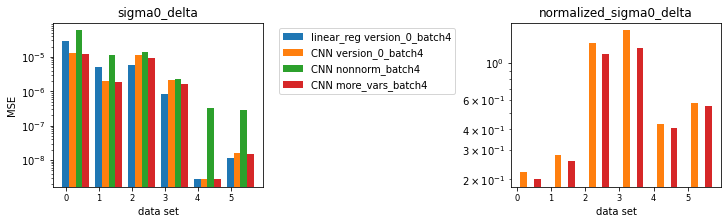

In [125]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
#fig.suptitle(r'Spatial correlation coefficient averaged in time: $R(\rho_c, parametrization)$')
x = np.arange(len(data_dict))
bar_width = 0.2

for col, feature in enumerate(['sigma0_delta', 'normalized_sigma0_delta']) :
    for ib, exp in enumerate(list_of_experiments) :
        if (feature in loss_vs_dataset[ib].keys()) :
            ax[col].bar(x+ib*bar_width, loss_vs_dataset[ib][feature], width=bar_width, label=exp.label+' '+exp.version_name, \
                        color=list(mcolors.TABLEAU_COLORS.values())[ib])
    ax[col].set(title=feature)
for axis in ax :
    axis.set_xlabel('data set')
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='log')
ax[0].set(ylabel='MSE')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Compare results with deterministic parametrization

## Image example

In [105]:
test_dl = common_datamodule.test_dataloader()[0]

In [106]:
test_di = iter(test_dl)

In [107]:
sample = next(test_di)

In [108]:
best_FCNN_model = LitPixelModel.load_from_checkpoint(exp0.checkpoint_callback.best_model_path)
best_CNN_model = CNN_Model_Class.load_from_checkpoint(exp1.checkpoint_callback.best_model_path)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'nnModel' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnModel'])`.
  rank_zero_warn(


In [109]:
idx = 0 #index inside the batch

In [110]:
snapshot = dict()
snapshot['true_error'] = np.squeeze(sample['sigma0_delta'][idx])
snapshot['FCNN'] = np.squeeze(best_FCNN_model.predict_step(sample, idx, 0)['sigma0_delta'][idx].detach().numpy())
snapshot['CNN'] = np.squeeze(best_CNN_model.predict_step(sample, idx, 0)['sigma0_delta'][idx].detach().numpy())
snapshot['lin_regr'] = best_lin_regr_model.predict_step(sample, idx, 0)['sigma0_delta'][idx].detach().numpy()

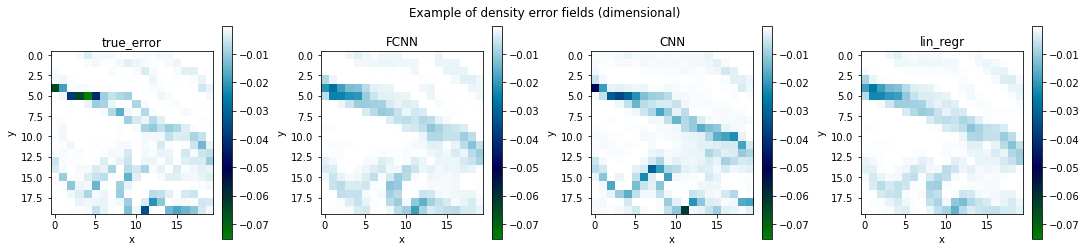

In [111]:
fig, ax = plt.subplots(ncols=len(snapshot.keys()), nrows=1, figsize=(15,3.5), constrained_layout=True)
fig.suptitle('Example of density error fields (dimensional)')
for i, key in enumerate(['true_error', 'FCNN', 'CNN', 'lin_regr']) :
    if i == 0 :
        img = ax[i].imshow(snapshot[key], cmap='ocean')
        fig.colorbar(img, ax=ax[i])
        color_min = img.colorbar.vmin
        color_max = img.colorbar.vmax
    else :
        img = ax[i].imshow(snapshot[key], cmap='ocean', vmin=color_min, vmax=color_max)
        #img = ax[i].imshow(snapshot[key], cmap='ocean')
        fig.colorbar(img, ax=ax[i])
    ax[i].set(title=key, xlabel='x', ylabel='y')
plt.show()

## Compare MSE across datasets

In [112]:
list_of_experiments = [exp_lin, exp0, exp1, exp2]

In [113]:
loss_vs_dataset = [dict() for i in range(len(list_of_experiments))]

In [114]:
for i, exp in enumerate(list_of_experiments) :
    test_dict = exp.test();
    for feature in ['sigma0_delta', 'normalized_sigma0_delta'] :
        if 'loss_test_'+feature+'/dataloader_idx_0' in test_dict[0] :
            loss_vs_dataset[i][feature] = [test_dict[ds]['loss_test_'+feature+'/dataloader_idx_'+str(ds)] for ds in range(len(data_dict))]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1             DataLoader 2
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 loss_test_sigma0_delta   2.9807622923288046e-05    5.105772301198285e-06    5.73755330412589e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 3             DataLoader 4             DataLoader 5
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 loss_test_sigma0_delta    8.234330985313128e-07   2.7605470709310285e-09   1.1844990577516574e-08
──────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0                     DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loss_test_normalized_sigma0_delta       0.49719464241355604               0.765852140645856
     loss_test_sigma0_delta           2.9188903647556792e-05            5.395201203682468e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 2                     DataLoader 3
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loss_test_normalized_sigma0_del

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0                     DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loss_test_normalized_sigma0_delta       0.22150872413695968              0.27957031286764905
     loss_test_sigma0_delta           1.3004156228515858e-05            1.969489942569614e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 2                     DataLoader 3
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loss_test_normalized_sigma0_de

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/srv/conda/envs/notebook/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1             DataLoader 2
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 loss_test_sigma0_delta    5.934950546406845e-05   1.1420704264546765e-05   1.4225897122584552e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 3             DataLoader 4             DataLoader 5
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 loss_test_sigma0_delta   2.3331787502357375e-06    3.166610066073707e-07   2.7769713210346833e-07
─────────

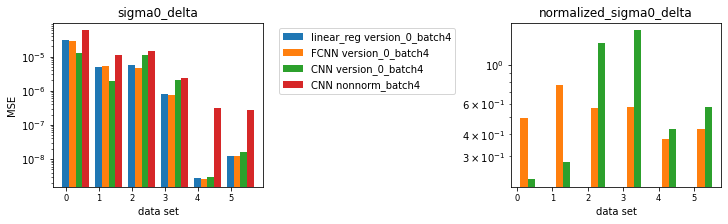

In [116]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
#fig.suptitle(r'Spatial correlation coefficient averaged in time: $R(\rho_c, parametrization)$')
x = np.arange(len(data_dict))
bar_width = 0.2

for col, feature in enumerate(['sigma0_delta', 'normalized_sigma0_delta']) :
    for ib, exp in enumerate(list_of_experiments) :
        if (feature in loss_vs_dataset[ib].keys()) :
            ax[col].bar(x+ib*bar_width, loss_vs_dataset[ib][feature], width=bar_width, label=exp.label+' '+exp.version_name, \
                        color=list(mcolors.TABLEAU_COLORS.values())[ib])
    ax[col].set(title=feature)
for axis in ax :
    axis.set_xlabel('data set')
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='log')
ax[0].set(ylabel='MSE')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()